In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm

import torch
import os
import bopt

In [93]:
from bopt.unigram_lm_tokenizers.loading import load_input_tokenizer
from bopt.unigram_lm_tokenizers import LatticeTokenizer
import json
from bopt.data import preprocessors
from bopt.utils import load_vocab
from bopt.learning_dynamics.constants import ENTROPY, TASK_LOSS, L1
from experiments.utils.datasets import list_collate
import numpy as np
from experiments.utils.io import load_tsv
import math
import ipywidgets as widgets


input_vocab = load_vocab(f"/export/a02/artifacts/boptv2/syn4_small/exp21-5/44/768/0.01/100/checkpoint-final/learned_vocab.txt")
input_vocab.specials = {"[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]", "[WBD]", "[SP1]", "[SP2]", "[SP3]", "[SP4]", "[SP5]"}
train_dataset = preprocessors["morpheme_prediction"]("/export/a01/corpora/vopt/syn/4/100/train.csv", None)
morphemes_dict = json.load(open("/export/a01/corpora/vopt/syn/4/full/morphemes.json", "rt"))
morphemes = [pair[1] for pl in morphemes_dict.values() for pair in pl]
morphemes_annotated = [f"{pair[1]}-{k}-{pair[0]}" for k, pl in morphemes_dict.items() for pair in pl]
all_units = input_vocab[:]
tokenizer = load_input_tokenizer("unigram", "lattice", input_vocab)
memoizer = dict()
print(morphemes_dict)

100it [00:00, 524288.00it/s]

{'prefix': [[0, 'xz'], [1, 'xx'], [2, 'o'], [3, 'ull'], [4, 'xi'], [5, 'yy'], [6, 'u'], [7, 'xu'], [8, 'il'], [9, 'lz']], 'root': [[0, 'zy'], [1, 'z'], [2, 'aox'], [3, 'xa'], [4, 'u'], [5, 'yii'], [6, 'xi'], [7, 'zu'], [8, 'x'], [9, 'oya'], [10, 'lu'], [11, 'yy'], [12, 'yx'], [13, 'iui'], [14, 'uy'], [15, 'zl'], [16, 'ua'], [17, 'xlx'], [18, 'xl'], [19, 'uu'], [20, 'ax'], [21, 'aaz'], [22, 'au'], [23, 'zo'], [24, 'l'], [25, 'ao'], [26, 'uz'], [27, 'uia'], [28, 'xo'], [29, 'yo'], [30, 'ox'], [31, 'oax'], [32, 'az'], [33, 'iu'], [34, 'aux'], [35, 'xu'], [36, 'zoo'], [37, 'i'], [38, 'ya'], [39, 'uuy'], [40, 'liz'], [41, 'zya'], [42, 'oy'], [43, 'zyl'], [44, 'o'], [45, 'll'], [46, 'ay'], [47, 'oa'], [48, 'a'], [49, 'uyz'], [50, 'aa'], [51, 'il'], [52, 'xui'], [53, 'oz'], [54, 'uou'], [55, 'ulz'], [56, 'zi'], [57, 'oua'], [58, 'io'], [59, 'auu'], [60, 'al'], [61, 'xxl'], [62, 'lyl'], [63, 'uoa'], [64, 'y'], [65, 'ily'], [66, 'ul'], [67, 'lo'], [68, 'xy'], [69, 'uxl'], [70, 'ol'], [71, 'xyx'

In [68]:
print("\n".join(sorted(morphemes_annotated)))

a-root-48
a-suffix-2
aa-root-50
aaz-root-21
al-root-60
all-root-81
ao-root-25
aox-root-2
au-root-22
aui-root-97
auu-root-59
aux-root-34
ax-root-20
ay-root-46
ayx-root-73
az-root-32
azu-suffix-3
i-root-37
ii-root-77
il-prefix-8
il-root-51
ily-root-65
io-root-58
iu-root-33
iui-root-13
ix-root-86
l-root-24
la-root-78
li-root-75
liz-root-40
ll-root-45
lo-root-67
lu-root-10
lua-root-96
lui-root-92
luo-suffix-4
lx-root-87
lx-suffix-5
ly-root-76
lyl-root-62
lz-prefix-9
lzy-root-98
o-prefix-2
o-root-44
oa-root-47
oax-root-31
oia-root-79
ol-root-70
oua-root-57
ox-root-30
ox-suffix-6
oxu-root-93
oy-root-42
oya-root-9
oz-root-53
u-prefix-6
u-root-4
u-suffix-1
ua-root-16
uax-root-72
uay-root-90
ui-root-80
uia-root-27
ul-root-66
ull-prefix-3
ull-root-91
ulz-root-55
uoa-root-63
uou-root-54
uu-root-19
uuy-root-39
ux-root-84
uxl-root-69
uxx-root-94
uy-root-14
uyz-root-49
uz-root-26
x-root-8
x-suffix-8
xa-root-3
xi-prefix-4
xi-root-6
xl-root-18
xlx-root-17
xo-root-28
xo-suffix-0
xu-prefix-7
xu-root-35


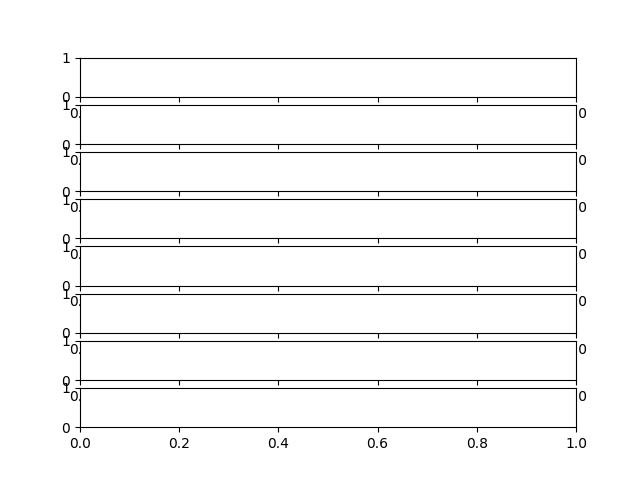

In [143]:
plt.clf()
plt.cla()
fig, ax = plt.subplots(8,1);

In [145]:
class Handler:

    def set_params(self, seed="44", l1="1.0", data="100", token="xz", steps="100", source=".*SP1.*", tokenization="xz-aa-ox"):
        self.seed = seed
        self.l1 = l1
        self.data = data
        self.token = token
        self.steps = steps
        self.source = source
        self.tokenization = tokenization
    
    def plot_single(self):
        global ax
        seed = self.seed
        l1 = self.l1
        data =  self.data
        token = self.token
        steps = self.steps
        source=  self.source
        tokenization = self.tokenization
        
        dir = f"/export/a02/artifacts/boptv2/syn4_small/exp21-5/{seed}/768/{l1}/{data}/dynamics"
        steps = int(steps)
        xs = list(range(steps))
        weights = []
        weights_grad_l1 = []
        weights_grad_entropy = []
        weights_grad_task = []
        conditionals = []
        conditionals_grad = []
        attentions = []
        attentions_grad = []
    
        for step in tqdm(range(steps)):
            if step %30 == 0:
                print(step)
            weights_lines = load_tsv(f"{dir}/expanded-dynamics-{step}/weights.txt")
            weights_line = next(filter(lambda x: x[0] == token, weights_lines))
            weight = math.exp(float(weights_line[1]))
            weights.append(weight)
            weights_grad_l1.append(-float(weights_line[2]) / len(weights_lines))
            os.system("awk -F '\t' '{{if ($1 == \"{0}\" && $3~/{3}/) {{ print $0 }}}}' < {1}/expanded-dynamics-{2}/lattice.tsv > tmp.tsv".format(token, dir, step, tokenization))
            lattice_lines = load_tsv(f"tmp.tsv")
            weights_grad_entropy.append([float(line[3]) / weight for line in lattice_lines])
            weights_grad_task.append([float(line[4]) / weight for line in lattice_lines])
            os.system("awk -F '\t' '{{if ($2 == \"{0}\" && $1~/{3}/ && $4~/{4}/) {{ print $0 }}}}' < {1}/expanded-dynamics-{2}/pairwise.tsv > tmp.tsv".format(token, dir, step, source, tokenization))
            pairwise_lines = load_tsv(f"tmp.tsv")
            conditionals.append([float(line[4]) for line in pairwise_lines])
            conditionals_grad.append([float(line[5]) for line in pairwise_lines])
            attentions.append([float(line[6]) / 96 for line in pairwise_lines])
            attentions_grad.append([float(line[7]) for line in pairwise_lines])
        weights_grad_task = [np.array(v) for v in weights_grad_task]
        weights_grad_task_sum = [v.sum() for v in weights_grad_task]
        weights_grad_task_err = [v.std() * len(v) for v in weights_grad_task] 
        conditionals = [np.exp(np.array(v)) for v in conditionals]
        conditionals_mask = [v != 0 for v in conditionals]
        conditionals_mean = [v[mask].mean() for v, mask in zip(conditionals, conditionals_mask)]
        conditionals_err = [v[mask].std() for v, mask in zip(conditionals, conditionals_mask)]
        conditionals_grad = [np.array(v)[mask] / u[mask]  for u, v, mask in zip(conditionals, conditionals_grad, conditionals_mask)]
        conditionals_grad_mean = [v.mean() for v in conditionals_grad]
        conditionals_grad_err = [v.std() for v in conditionals_grad]
        attentions = [np.array(v) for v in attentions]
        attentions_mean = [v[mask].mean() for v, mask in zip(attentions, conditionals_mask)]
        attentions_err = [v[mask].std() for v, mask in zip(attentions, conditionals_mask)]
        attentions_grad = [np.array(v) for v in attentions_grad]
        attentions_grad_mean = [v[mask].mean() for v, mask in zip(attentions_grad, conditionals_mask)]
        attentions_grad_err = [v[mask].std() for v, mask in zip(attentions_grad, conditionals_mask)]

        attention_overflow = [np.maximum(v1 - v2, 0) for v1, v2 in zip(attentions, conditionals)]
        
        attention_overflow_mean = [v[mask].mean() for v, mask in zip(attention_overflow, conditionals_mask)]
        attention_overflow_std = [v[mask].std() for v, mask in zip(attention_overflow, conditionals_mask)]
        
        # weights traj
        ax[0].set_title("weights trajectory")
        ax[0].plot(xs, weights, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        for x, y, dytask, dyl1 in zip(xs, weights, weights_grad_task_sum, weights_grad_l1):
            ax[0].arrow(x,y,0, dytask/ 0.02, color="red")
            ax[0].arrow(x,y,0, dyl1/0.02, color="blue")
        # weights grad task traj
        ax[1].set_title("weights grad task trajectory")
        ax[1].errorbar(xs, weights_grad_task_sum, yerr=weights_grad_task_err, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[1].hlines(0, 0, steps, color="red")

        # attention traj
        ax[2].set_title("attention trajectory")
        ax[2].errorbar(xs, attentions_mean, yerr=attentions_err, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[2].hlines(0, 0, steps, color="red")

        # attention traj
        ax[3].set_title("attention grad trajectory")
        ax[3].errorbar(xs, attentions_grad_mean, yerr=attentions_grad_err, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[3].hlines(0, 0, steps, color="red")

        # conditionals traj
        ax[4].set_title("conditionals trajectory")
        ax[4].errorbar(xs, conditionals_mean, yerr=conditionals_err, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[4].hlines(0, 0, steps, color="red")

        # conditionals traj
        ax[5].set_title("conditionals grad trajectory")
        ax[5].errorbar(xs, conditionals_grad_mean, yerr=conditionals_grad_err, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[5].hlines(0, 0, steps, color="red")

        # attention overflow traj
        ax[6].set_title("attention overflow trajectory")
        ax[6].errorbar(xs, attention_overflow_mean, yerr=attention_overflow_std, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[6].hlines(0, 0, steps, color="red")
        
        # weights grad l1 traj
        ax[-1].set_title("weights grad l1 trajectory")
        ax[-1].plot(xs, weights_grad_l1, label=f"{token}-{seed}-{l1}-{data}-{source}-{tokenization}")
        ax[-1].hlines(0, 0, steps, color="red")
        for a in ax:
            a.legend()

    def clear(self):
        global ax
        for a in ax:
            a.clear()



handler = Handler()
handler.clear()
interact(handler.set_params);
buttonadd = widgets.Button(description='Add')
buttonclear = widgets.Button(description='Clear')
buttonadd.on_click(lambda _: handler.plot_single())
buttonclear.on_click(lambda _: handler.clear())
widgets.VBox([buttonadd, buttonclear])

interactive(children=(Text(value='44', description='seed'), Text(value='1.0', description='l1'), Text(value='1…

In [132]:
import subprocess
dir = "/export/a02/artifacts/boptv2/syn4_small/exp21-5/44/768/0.01/100/dynamics/expanded-dynamics-0"
print(os.listdir(dir))
ps = subprocess.Popen(('cat', f'{dir}/pairwise.tsv'), stdout=subprocess.PIPE)
output = subprocess.check_output(('grep', 'xiuya'), stdin=ps.stdout)
print(output.decode())

['pairwise.ex.tsv', 'pairwise.tsv', 'lattice.ex.tsv', 'lattice.tsv', 'weights.txt']
[SP1]	[SP1]	xiuya	xi-uy-a	0.0	-1.7e-05	1.5e+01	-0.00022
[SP1]	[SP2]	xiuya	xi-uy-a	0.0	-1.6e-06	1.6e+01	-8.3e-05
[SP1]	[SP3]	xiuya	xi-uy-a	0.0	-4.9e-05	1.6e+01	-0.00037
[SP1]	x	xiuya	xi-uy-a	-0.69	2.1e-05	7.8	-0.00012
[SP1]	xi	xiuya	xi-uy-a	-1.4	9.7e-07	3.8	-6.6e-05
[SP1]	xiu	xiuya	xi-uy-a	-2.1	1.3e-05	2.1	0.00035
[SP1]	xiuy	xiuya	xi-uy-a	-2.8	1.7e-06	1.0	-3.1e-05
[SP1]	xiuya	xiuya	xi-uy-a	-2.8	2.2e-06	1.0	8.8e-05
[SP1]	i	xiuya	xi-uy-a	-1.4	-8.8e-06	3.8	-0.00015
[SP1]	iu	xiuya	xi-uy-a	-2.1	8.8e-07	2.1	-3.6e-05
[SP1]	iuy	xiuya	xi-uy-a	-2.8	1.2e-06	0.99	-6.5e-05
[SP1]	iuya	xiuya	xi-uy-a	-2.8	2.6e-06	1.0	-3.1e-06
[SP1]	u	xiuya	xi-uy-a	-1.4	2.1e-06	4.2	-0.00013
[SP1]	uy	xiuya	xi-uy-a	-2.1	-2.9e-06	2.1	-0.00026
[SP1]	uya	xiuya	xi-uy-a	-2.1	-1.6e-06	2.1	-0.00026
[SP1]	y	xiuya	xi-uy-a	-1.4	5e-06	4.0	-4.6e-05
[SP1]	ya	xiuya	xi-uy-a	-1.4	1.1e-05	4.1	0.00012
[SP1]	a	xiuya	xi-uy-a	-0.69	1.8e-05	8.0	0.00012
[SP2]	[S